# Pre-process ESA Snow CCI data

- Snow Cover Fraction Climate Research Data Package: http://snow-cci.enveo.at/
- summer path: `/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW`

Check missing values, linear interpolation on time, and spatial aggregation

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
# client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
client = Client(n_workers=8, threads_per_worker=1, memory_limit='2GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:42629 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.00 GB


In [18]:
client.close()

In [3]:
path_snow_CCI = '/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg'
path_AVHRR = path_snow_CCI+'/AVHRR_MERGED/v2.0'
path_MODIS = path_snow_CCI+'/MODIS/v2.0'

In [4]:
ds = xr.open_mfdataset(path_AVHRR+'/1982/01/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc', parallel=True)
ds

,Array,Chunk
Bytes,1.73 MB,57.60 kB
Shape,"(30, 3600, 2)","(1, 3600, 2)"
Count,120 Tasks,30 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.46 MB,115.20 kB
Shape,"(30, 7200, 2)","(1, 7200, 2)"
Count,120 Tasks,30 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [5]:
da = ds.scfg
da

,Array,Chunk
Bytes,3.11 GB,103.68 MB
Shape,"(30, 3600, 7200)","(1, 3600, 7200)"
Count,90 Tasks,30 Chunks
Type,float32,numpy.ndarray


In [6]:
scf = da.where(da <= 100)

## Test global
subset below

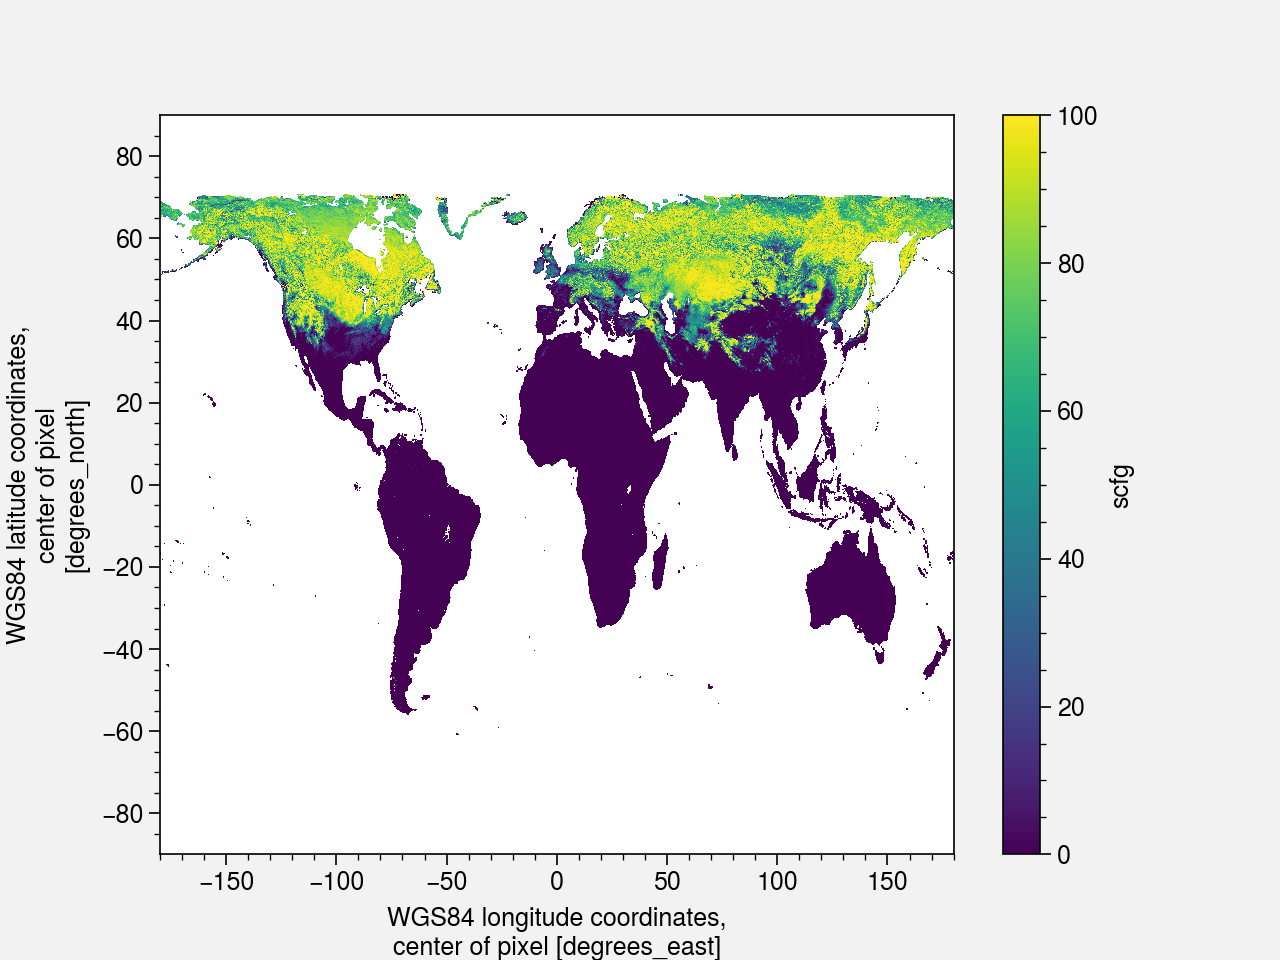

In [13]:
scf.mean('time').plot()

In [7]:
data_coverage = ((scf.count('time') / scf.time.size)*100).load()

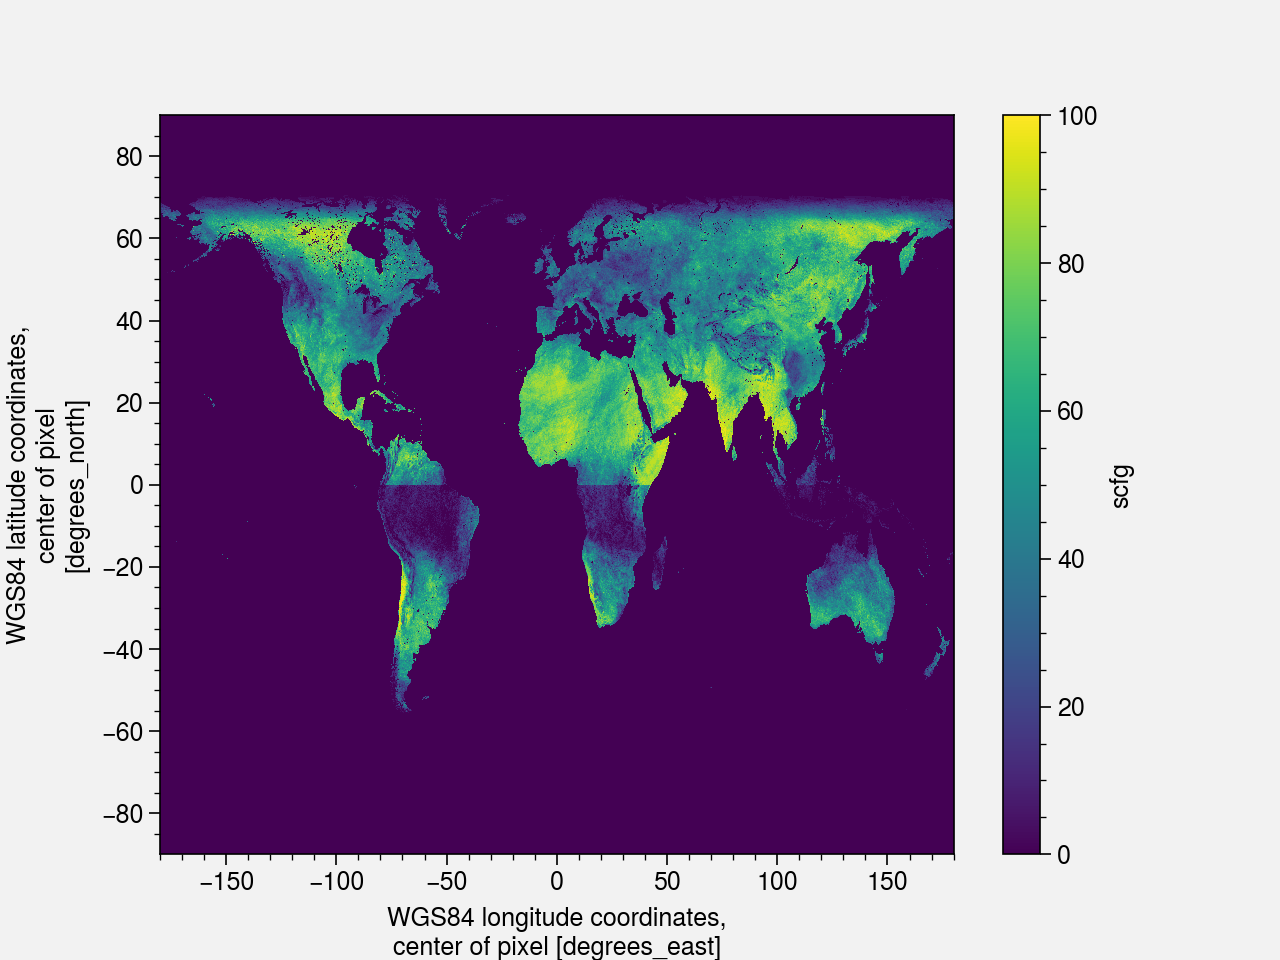

In [30]:
data_coverage.plot()

## Subset

In [7]:
latlim = slice(0,60)
lonlim = slice(-30, 50)

scf_subset = scf.sel(lat=latlim, lon=lonlim).load()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


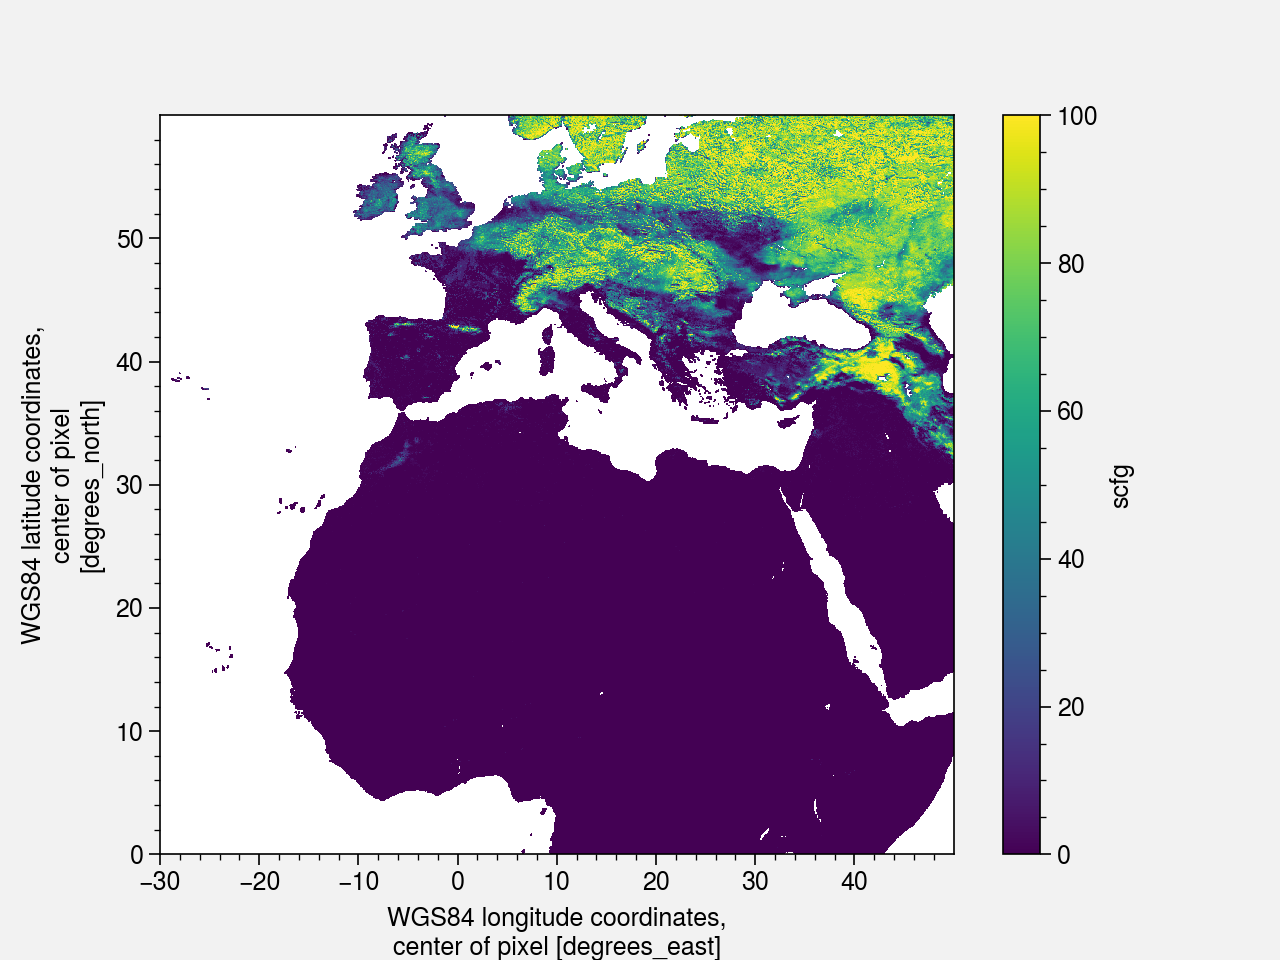

In [8]:
scf_subset.mean('time').plot()

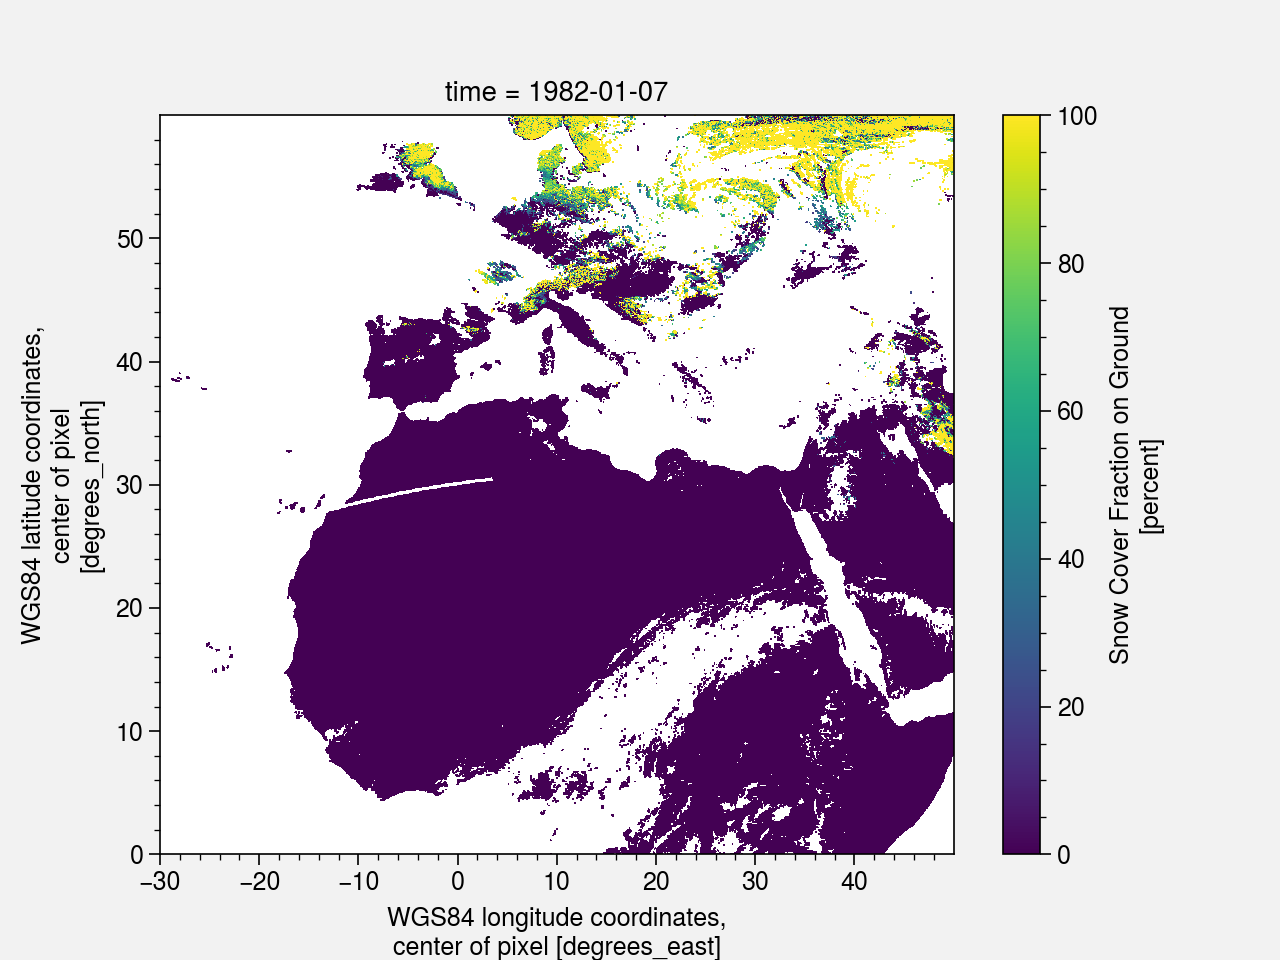

In [27]:
scf_subset[6].plot()

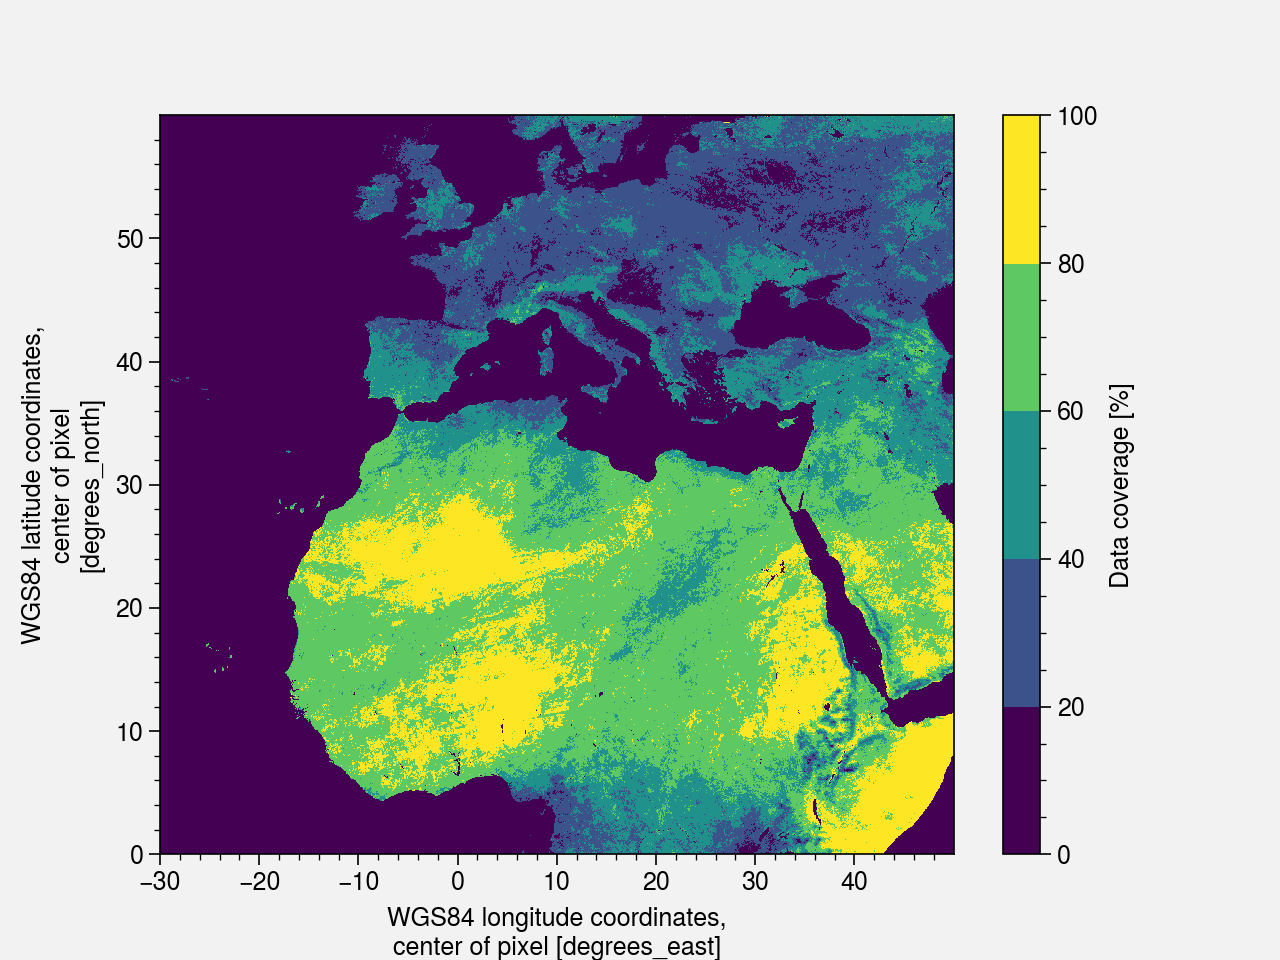

In [9]:
data_coverage = ((scf_subset.count('time') / scf.time.size)*100)
data_coverage.name = 'Data coverage'
data_coverage.attrs['units'] = '%'

data_coverage.plot(levels=plot.arange(0, 100, 20))

## Linear temporal gapfill

In [31]:
scf_subset

<xarray.DataArray 'scfg' (time: 30, lat: 1200, lon: 1600)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan, 100.],
        [ nan,  nan,  nan, ..., 100.,  nan,  nan],
        [ nan,  nan,  nan, ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,   0.,   0.,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [ nan,  nan,  nan, ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,   0.,   0.,   0.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,   0.,   0.,   0.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 0.025 0.075 0.125 0.175 ... 59.83 59.88 59.92 59.97
  * lon      (lon) float64 -29.98 -29.92 -29.88 -29.83 ... 49.88 49.92 49.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

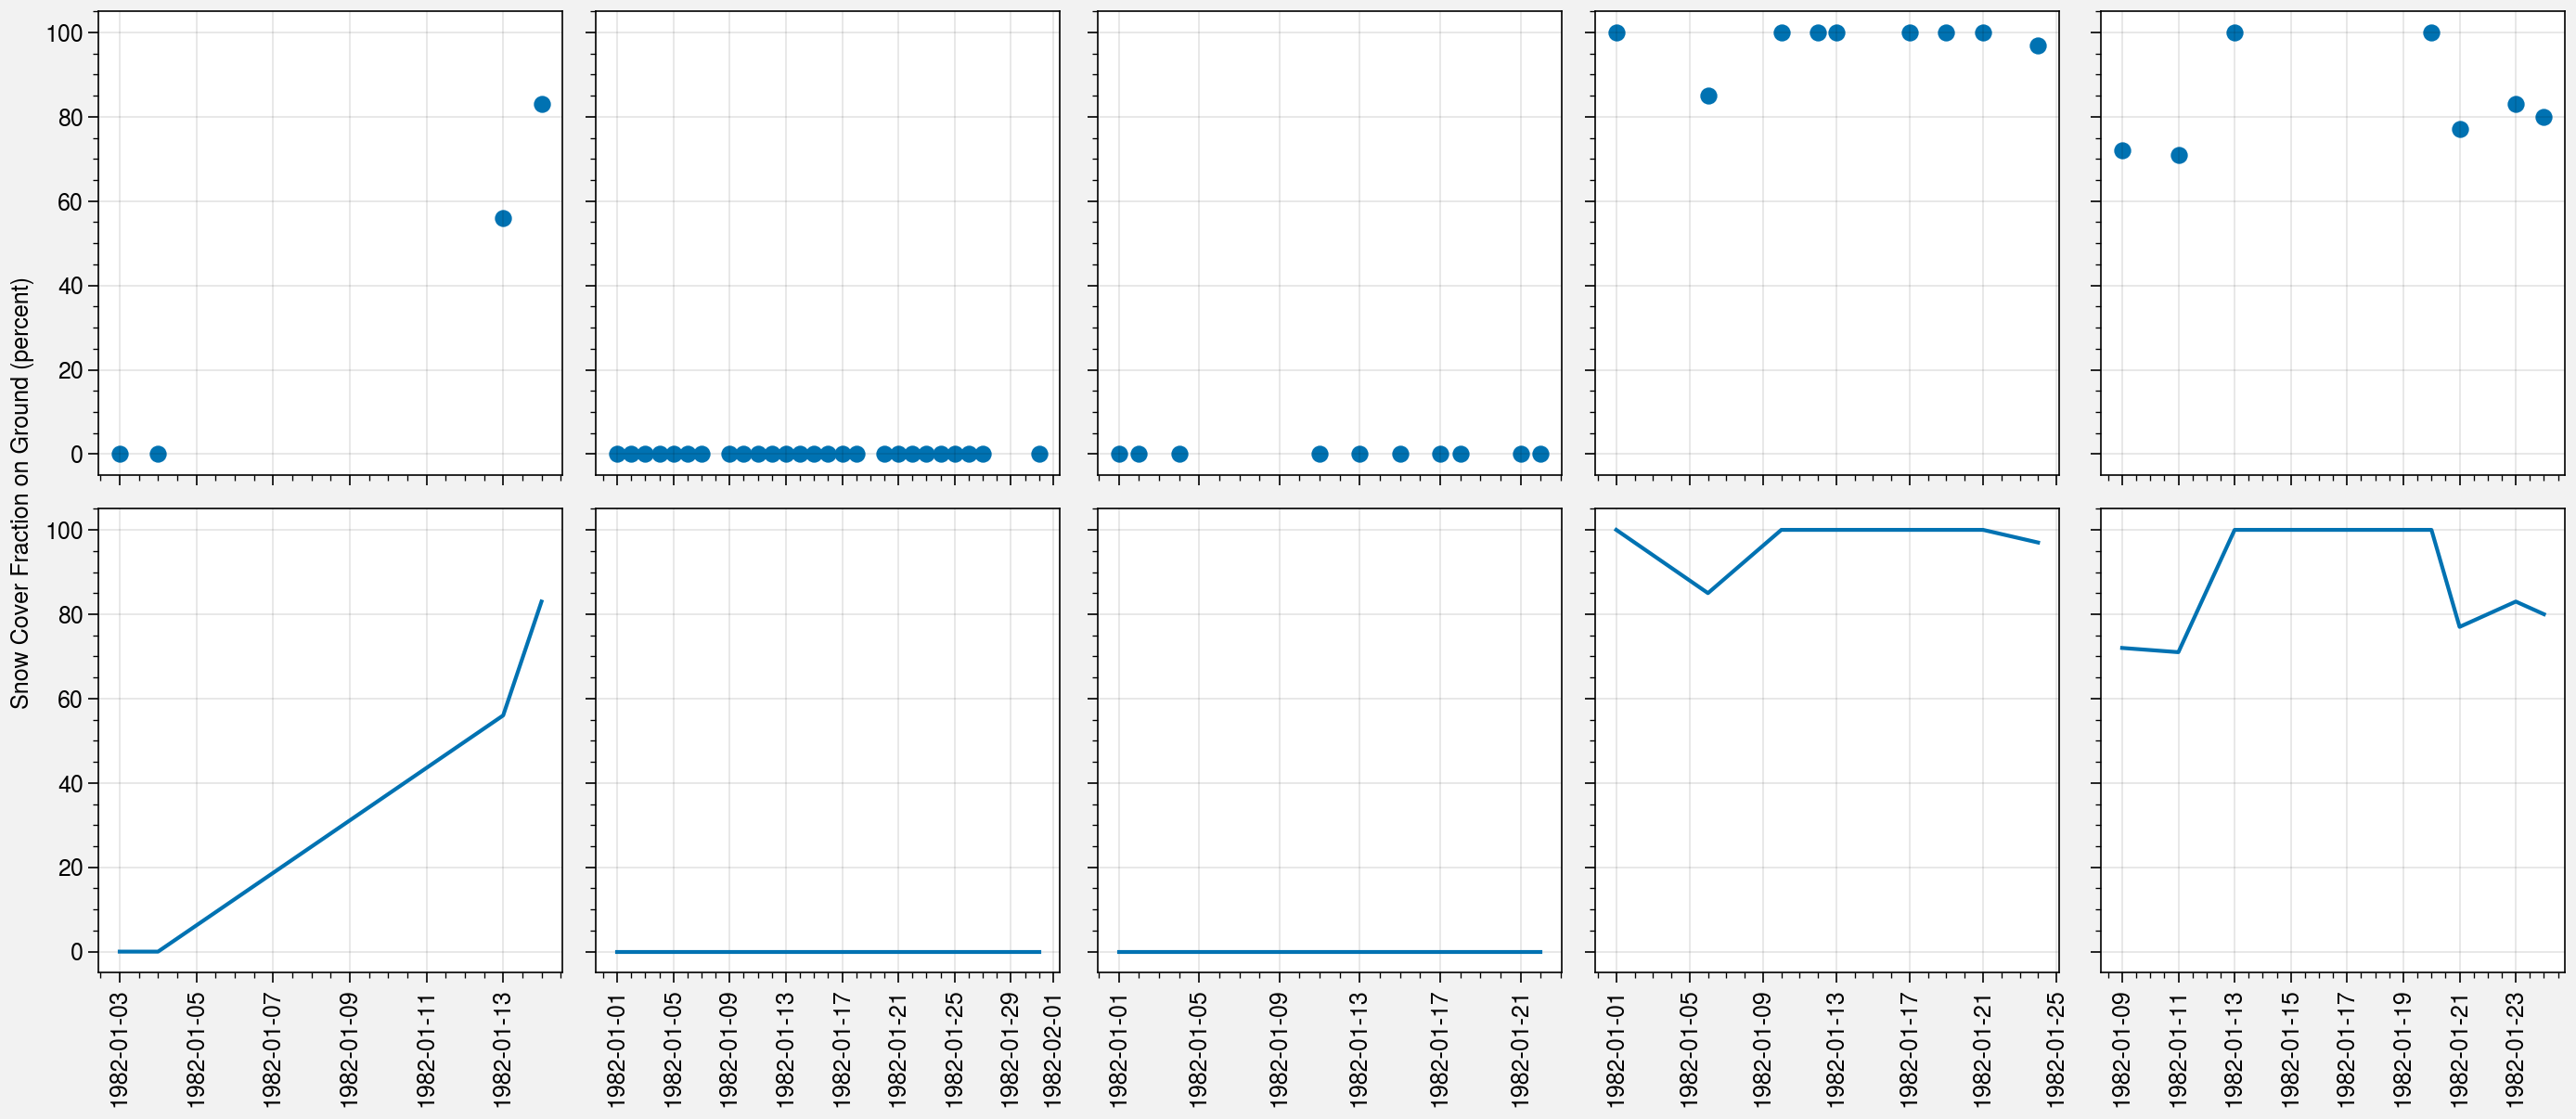

In [61]:
latlons = [[45, 20], [25, 0], [45, 0], [55, 40], [50, 40]]

fig, axs = plot.subplots(nrows=2, ncols=len(latlons))

for i, latlon in enumerate(latlons):
    axs[0, i].scatter(scf_subset.time.values, scf_subset.sel(lon=latlon[1], lat=latlon[0], method='nearest'))
    axs[1, i].plot(scf_subset.sel(lon=latlon[1], lat=latlon[0], method='nearest').interpolate_na('time', method='linear'))    

## Optimization

In [19]:
scf_subset.chunk({'lat': int(scf_subset.lat.size/2), 'lon': int(scf_subset.lon.size/4)})

<xarray.DataArray 'scfg' (time: 30, lat: 1200, lon: 1600)>
dask.array<xarray-<this-array>, shape=(30, 1200, 1600), dtype=float32, chunksize=(30, 600, 400), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 0.025 0.075 0.125 0.175 ... 59.83 59.88 59.92 59.97
  * lon      (lon) float64 -29.98 -29.92 -29.88 -29.83 ... 49.88 49.92 49.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [14]:
%%time
# client = Client(n_workers=8, threads_per_worker=1, memory_limit='2GB') -> 8 chunks pour 8 workers (to adapt with the machine)
# vu que le taf peut être totalement parallélisé, ajouté des thread n'augmente pas la vitesse de calcul
scf_subset.chunk({'lat': int(scf_subset.lat.size/2), 'lon': int(scf_subset.lon.size/4)}).interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10)).compute()

CPU times: user 2.36 s, sys: 457 ms, total: 2.82 s
Wall time: 15.1 s


<xarray.DataArray 'scfg' (time: 30, lat: 1200, lon: 1600)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan, 100.      ],
        [       nan,        nan,        nan, ..., 100.      ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 100.      ,
         100.      , 100.      ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,   0.      ,
           0.      ,   0.      ],
        [       nan,        nan,        nan, ...,   0.      ,
           0.      ,   0.      ],
        [       nan,        nan,        nan, ...,   0.      ,
           0.      ,   0.      ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 0.025 0.075 0.125 0.175 ... 59.83 59.88 59.92 59.97
  * lon      (lon) float64 -29.98 -29.92 -29.88 -29.83 ... 49.88 49.92 49.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [118]:
%%time
scf_subset.interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10))

CPU times: user 1min, sys: 9.98 s, total: 1min 10s
Wall time: 57.7 s


<xarray.DataArray 'scfg' (time: 30, lat: 1200, lon: 1600)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan, 100.      ],
        [       nan,        nan,        nan, ..., 100.      ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 100.      ,
         100.      , 100.      ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,   0.      ,
           0.      ,   0.      ],
        [       nan,        nan,        nan, ...,   0.      ,
           0.      ,   0.      ],
        [       nan,        nan,        nan, ...,   0.      ,
           0.      ,   0.      ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 0.025 0.075 0.125 0.175 ... 59.83 59.88 59.92 59.97
  * lon      (lon) float64 -29.98 -29.92 -29.88 -29.83 ... 49.88 49.92 49.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

## Gapfilling

In [20]:
scf_subset_interp = scf_subset.chunk({'lat': int(scf_subset.lat.size/2), 'lon': int(scf_subset.lon.size/4)}).interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10)).load()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


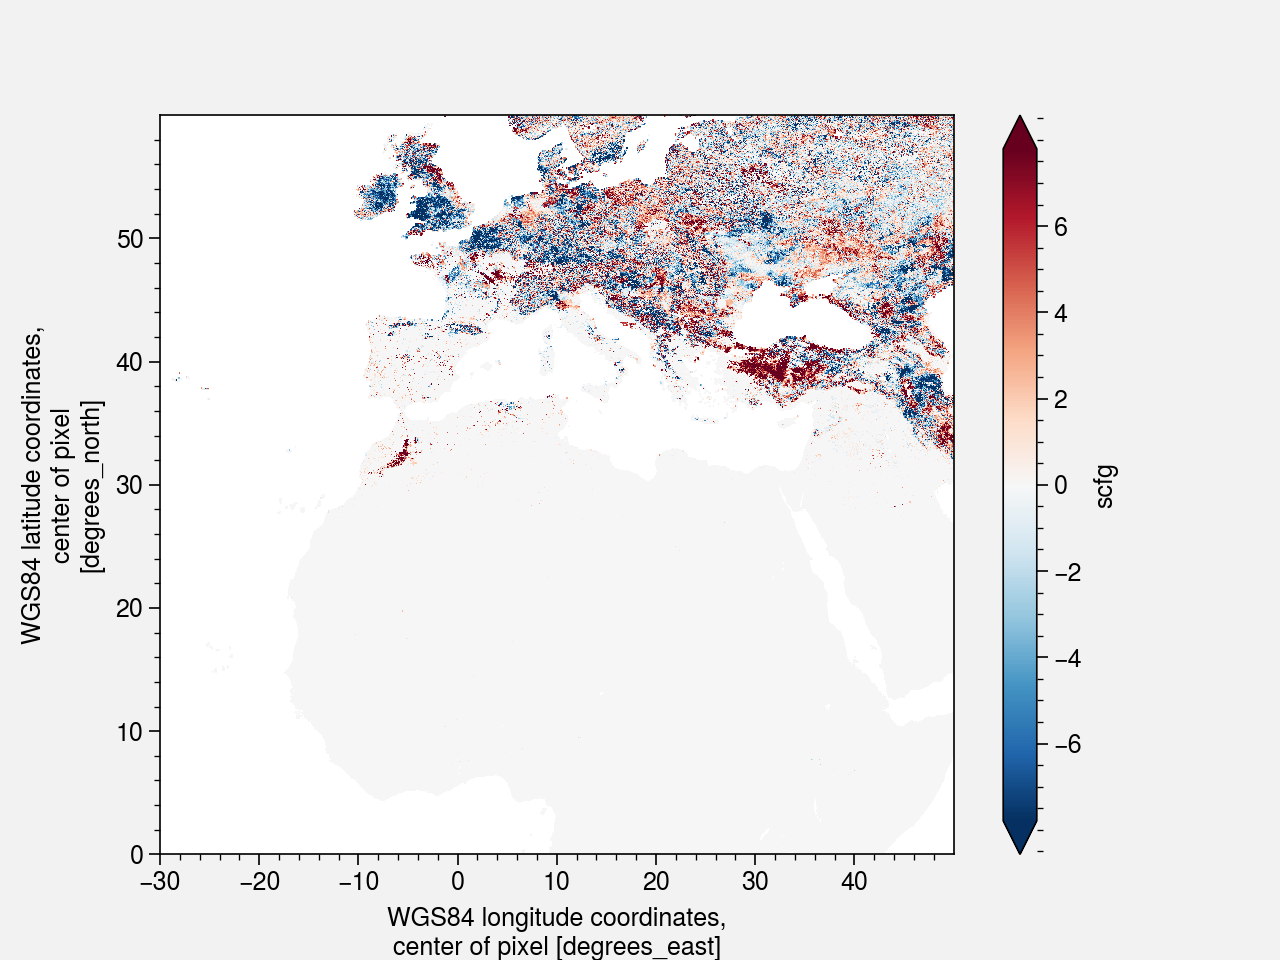

In [21]:
(scf_subset_interp.mean('time') - scf_subset.mean('time')).plot(robust=True)

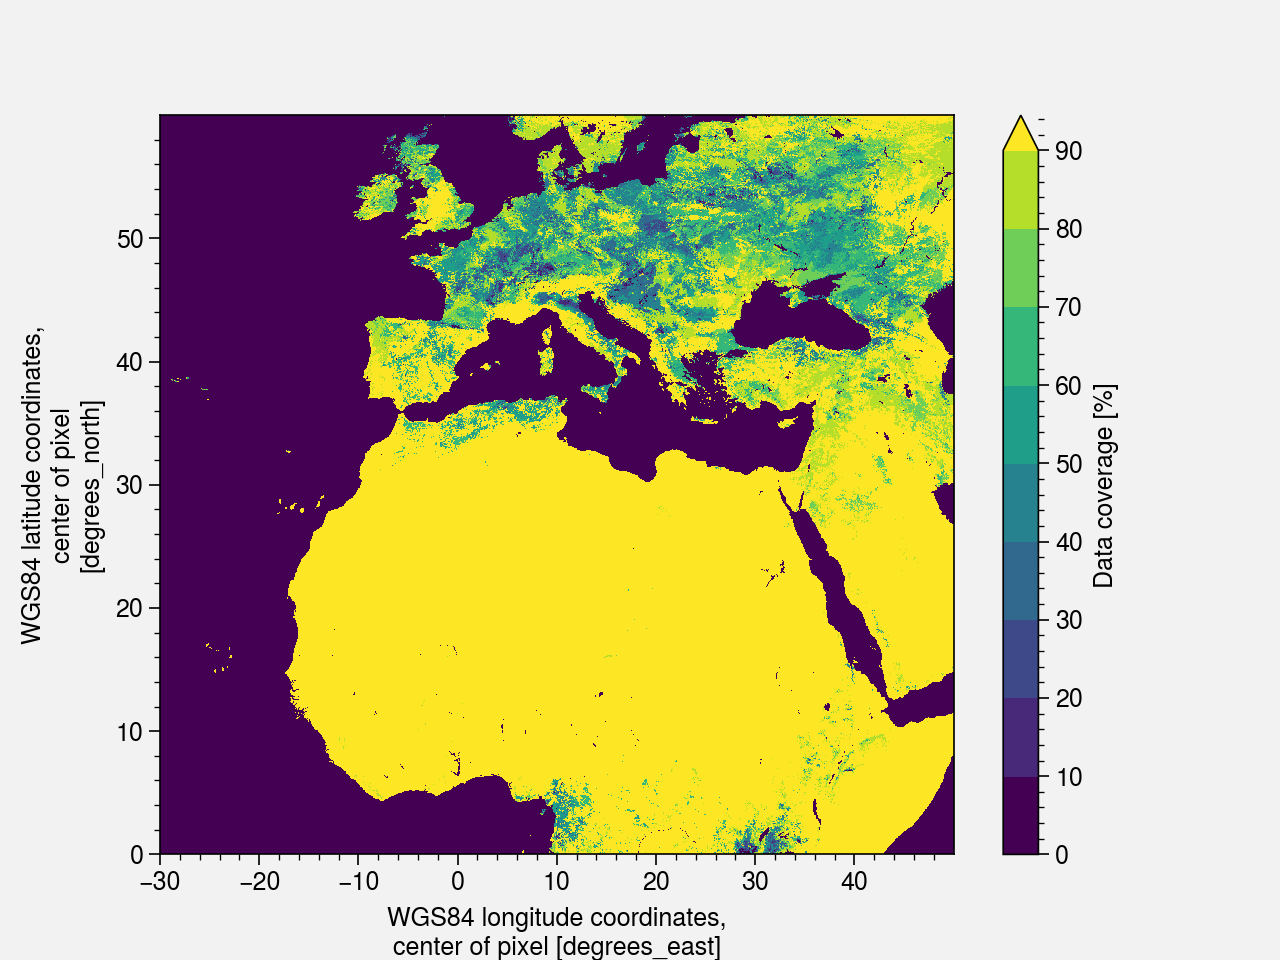

In [47]:
data_coverage_interp = ((scf_subset_interp.count('time') / scf.time.size)*100)
data_coverage_interp.name = 'Data coverage'
data_coverage_interp.attrs['units'] = '%'

data_coverage_interp.plot(levels=plot.arange(0, 90, 10), extend='max')

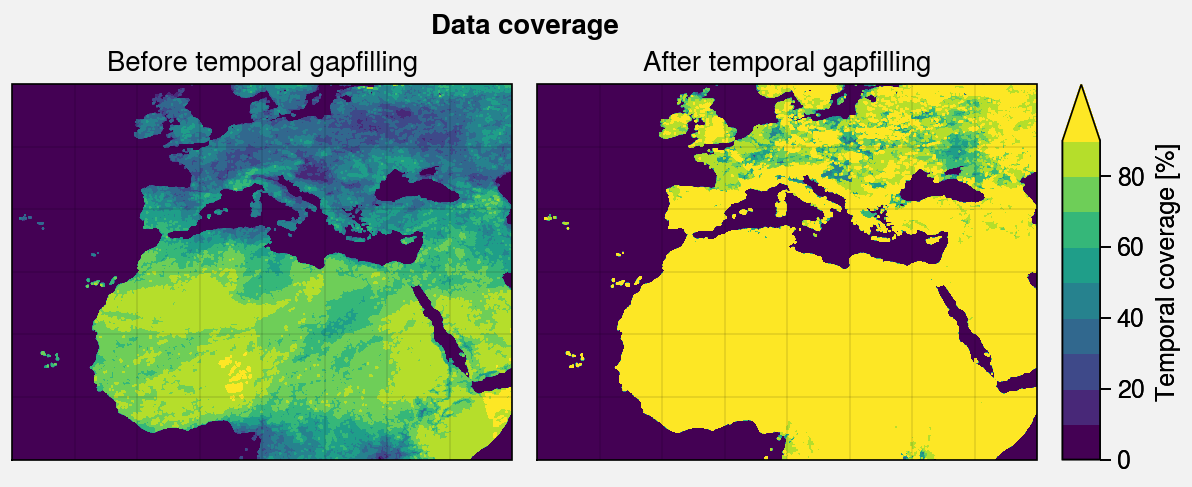

In [54]:
fig, axs = plot.subplots(ncols=2, proj='cyl')

levels = plot.arange(0, 90, 10)
extend = 'max'
cmap='viridis'

m = axs[0].contourf(data_coverage, levels=levels, extend=extend, cmap=cmap)
axs[1].contourf(data_coverage_interp, levels=levels, extend=extend, cmap=cmap)

fig.colorbar(m, label='Temporal coverage [%]')

for title, ax in zip(['Before temporal gapfilling', 'After temporal gapfilling'], axs):
    ax.format(title=title)
    
axs.format(
    suptitle='Data coverage',
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

## Monthly mean

In [23]:
scf_monsubset_interp = scf_subset_interp.groupby('time.month').mean('time')

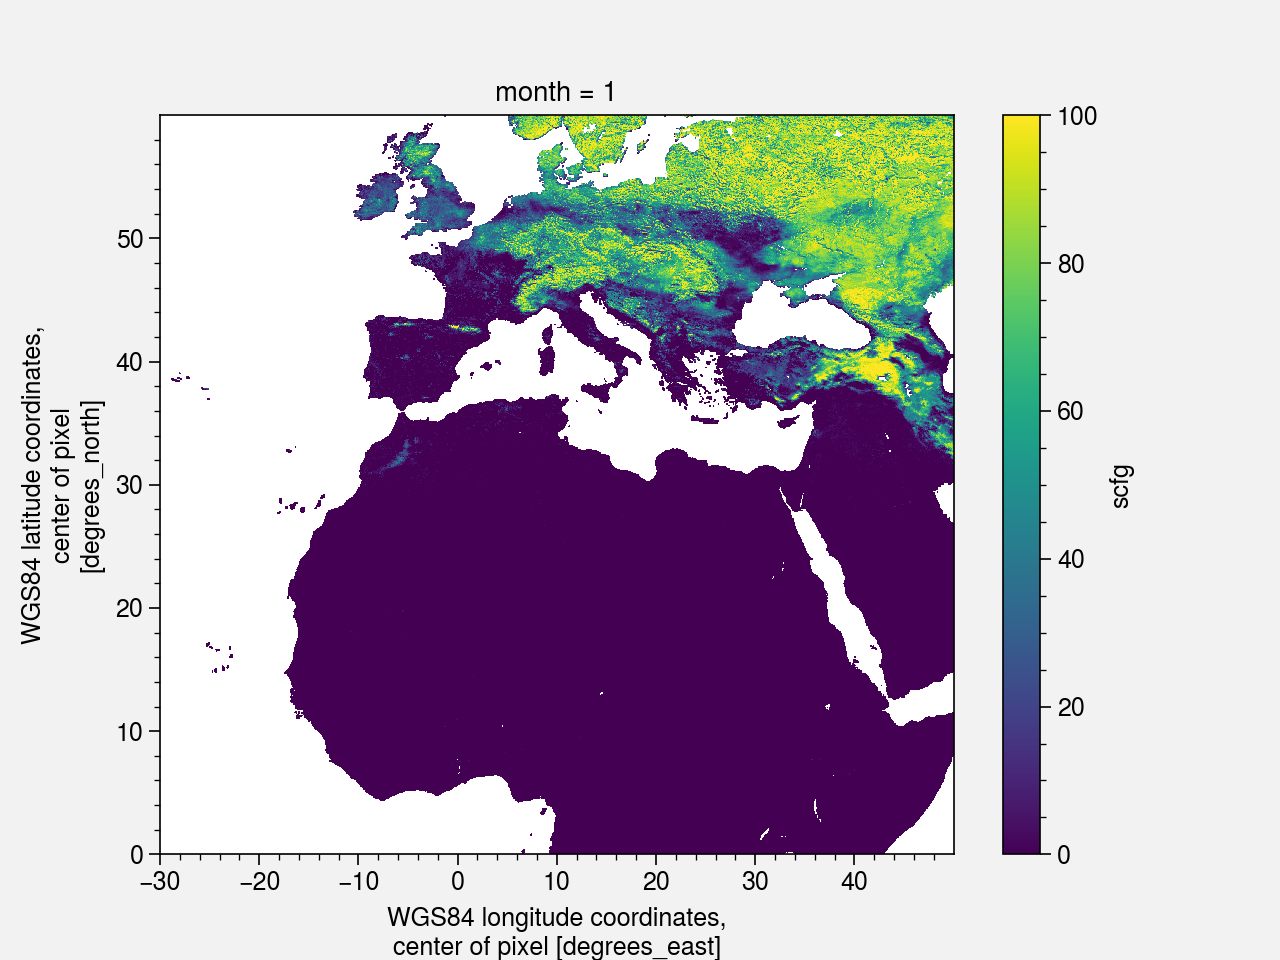

In [25]:
scf_monsubset_interp[0].plot()

## Spatial aggregation to 25km

In [56]:
scf_monsubset_interp.lat[1] - scf_monsubset_interp.lat[0]

<xarray.DataArray 'lat' ()>
array(0.05)

In [58]:
0.25/0.05

5.0

In [61]:
scf_monsubset_interp_coarsen = scf_monsubset_interp.coarsen(lat=5, lon=5).mean()

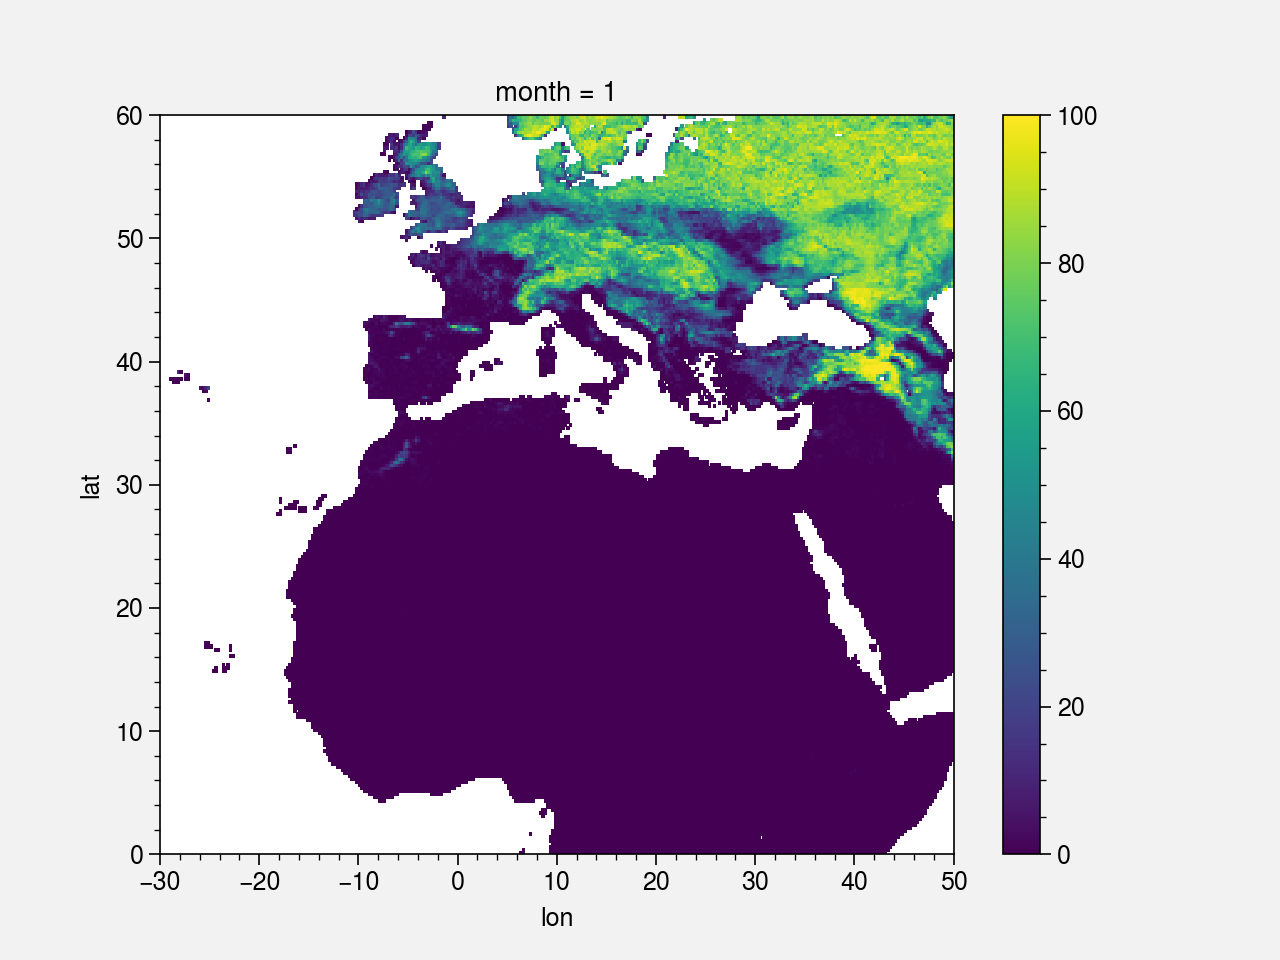

In [64]:
scf_monsubset_interp_coarsen[0].plot()